In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [2]:
!pip install torch torchvision timm pycocotools albumentations --quiet
!pip install effdet  # EfficientDet PyTorch implementation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.3 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

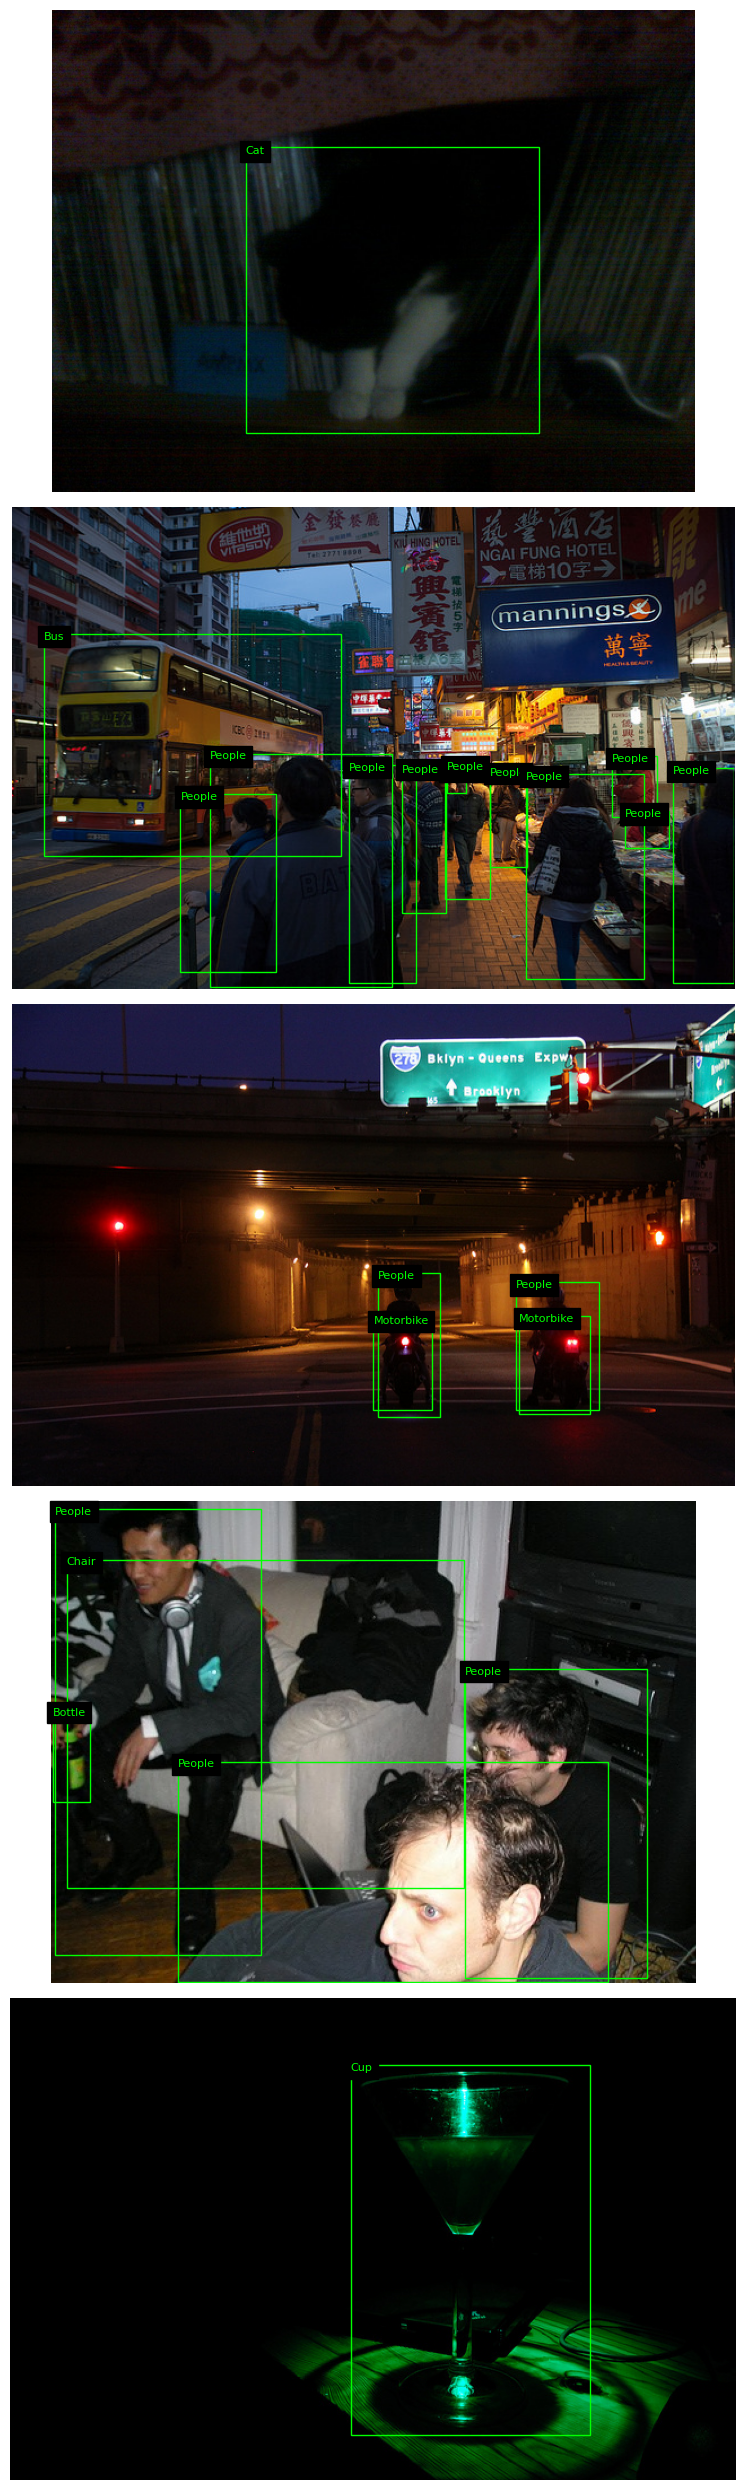

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Paths
dataset_path = "/kaggle/input/object-detection-exdark/ExDark"
annot_path = "/kaggle/input/object-detection-exdark/ExDark_Annno"

# Get all image paths
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Select random images
random.seed(42)
selected_images = random.sample(image_paths, 5)

# Visualization
fig, axes = plt.subplots(nrows=len(selected_images), ncols=1, figsize=(10, 5*len(selected_images)))
if len(selected_images) == 1: axes = [axes]  # Handle single image case

for ax, img_path in zip(axes, selected_images):
    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Build annotation path
    rel_path = os.path.relpath(img_path, dataset_path)  # e.g. "Bicycle/2015_00001.png"
    annot_file_path = os.path.join(annot_path, rel_path + ".txt")  # Key fix: add .txt to full filename
    
    # Check annotation existence
    if not os.path.exists(annot_file_path):
        print(f"Annotation {annot_file_path} not found - skipping")
        continue
    
    # Parse annotations
    boxes = []
    labels = []
    with open(annot_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('%') or not line: continue
            parts = line.split()
            class_name = parts[0]
            x, y, w, h = map(int, parts[1:5])
            boxes.append((x, y, w, h))
            labels.append(class_name)
    
    # Draw annotations
    ax.imshow(image)
    for (x, y, w, h), label in zip(boxes, labels):
        rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                               edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y-2, label, color='lime', 
               fontsize=8, va='top', backgroundcolor='black')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [1]:
import os
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torch.cuda import amp  # Mixed precision

In [2]:
# Configuration (MODIFIED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 10
BATCH_SIZE = 8  # Increased batch size
LEARNING_RATE = 0.005
IMG_SIZE = 224  # Reduced image size
CLASSES = ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 
          'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
NUM_CLASSES = len(CLASSES) + 1
DATASET_PATH = "/kaggle/input/object-detection-exdark/ExDark"
ANNOT_PATH = "/kaggle/input/object-detection-exdark/ExDark_Annno"

In [4]:
# Custom Dataset (MODIFIED)
class ExDarkDataset(Dataset):
    def __init__(self, root_dir, annot_dir, classes, transform=None):
        self.root_dir = root_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.class_to_idx = {cls: i+1 for i, cls in enumerate(classes)}
        self.image_paths = []
        self.annotations = {}  # Cache annotations
        
        # Collect valid image paths and pre-load annotations
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(root, file)
                    annot_path = self._get_annot_path(img_path)
                    if os.path.exists(annot_path):
                        with open(annot_path, 'r') as f:
                            lines = [line.strip() for line in f 
                                     if line.strip() and not line.startswith('%')]
                        if lines:
                            self.image_paths.append(img_path)
                            self.annotations[img_path] = lines

    def _get_annot_path(self, img_path):
        rel_path = os.path.relpath(img_path, self.root_dir)
        return os.path.join(self.annot_dir, rel_path + ".txt")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Resize image upfront (MODIFIED)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        scale_x, scale_y = IMG_SIZE/w, IMG_SIZE/h
        
        boxes = []
        labels = []
        
        for line in self.annotations[img_path]:
            parts = line.split()
            class_name = parts[0]
            x, y, w_box, h_box = map(int, parts[1:5])
            
            # Scale bounding boxes (MODIFIED)
            xmin = max(0, min(w-1, x)) * scale_x
            ymin = max(0, min(h-1, y)) * scale_y
            xmax = max(0, min(w, x + w_box)) * scale_x
            ymax = max(0, min(h, y + h_box)) * scale_y
            
            # Skip invalid boxes
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue
                
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[class_name])
        
        if len(boxes) == 0:
            return self[(idx + 1) % len(self)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Normalize image (MODIFIED)
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image = torchvision.transforms.functional.normalize(
            image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, {'boxes': boxes, 'labels': labels}

In [5]:
# Model Architecture (MODIFIED)
def create_model():
    backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
    backbone.out_channels = 960
    
    # Adjusted anchor sizes for 224x224 input
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),),  # Smaller anchors
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    return FasterRCNN(
        backbone,
        num_classes=NUM_CLASSES,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

In [6]:
# Data Loading (UNCHANGED)
def collate_fn(batch):
    return tuple(zip(*batch))

def create_datasets():
    full_dataset = ExDarkDataset(DATASET_PATH, ANNOT_PATH, CLASSES)
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    return torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_dataset, val_dataset, test_dataset = create_datasets()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

In [7]:
# Training Setup (MODIFIED)
model = create_model().to(DEVICE)
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = amp.GradScaler()  # Mixed precision

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 127MB/s] 
/tmp/ipykernel_31/699268303.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)`

In [8]:
# Training and Evaluation (MODIFIED)
train_loss_history = []
val_loss_history = []  # Added for validation loss
val_map_history = []
test_map_history = []
val_acc_history = []
test_acc_history = []
all_val_preds = []
all_val_targets = []
all_test_preds = []
all_test_targets = []

for epoch in range(NUM_EPOCHS):
    # Training with mixed precision
    model.train()
    epoch_train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Train Epoch {epoch+1}")
    for images, targets in train_bar:
        images = [img.to(DEVICE, non_blocking=True) for img in images]
        targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
        
        with torch.amp.autocast('cuda'):  # Updated autocast usage
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_train_loss += losses.item()
        train_bar.set_postfix(loss=losses.item())
    
    train_loss = epoch_train_loss/len(train_loader)
    train_loss_history.append(train_loss)
    lr_scheduler.step()

    # Validation - only predictions (MODIFIED)
    model.eval()
    metric = MeanAveragePrecision()
    preds_for_cm = []
    targets_for_cm = []
    correct = 0
    total = 0
    epoch_val_loss = 0  # Track validation loss
    val_batches = 0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            # Compute validation loss (switch to train mode temporarily)
            model.train()
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets_gpu)
                losses = sum(loss for loss in loss_dict.values())
                epoch_val_loss += losses.item()
                val_batches += 1
            model.eval()
            
            # Get predictions
            with torch.amp.autocast('cuda'):
                predictions = model(images)
            
            metric.update(predictions, targets_gpu)
            
            # Accuracy calculation
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct += matches
                    total += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm.extend(pred_labels)
                    targets_for_cm.extend(true_labels)
    
    val_loss = epoch_val_loss / val_batches if val_batches > 0 else 0
    val_loss_history.append(val_loss)

    map_metrics = metric.compute()
    val_map = map_metrics['map'].item()
    val_map_history.append(val_map)
    val_acc = correct / total if total > 0 else 0
    val_acc_history.append(val_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_val_preds = preds_for_cm
        all_val_targets = targets_for_cm

    # Testing - only predictions (MODIFIED)
    metric_test = MeanAveragePrecision()
    preds_for_cm_test = []
    targets_for_cm_test = []
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc=f"Test Epoch {epoch+1}"):
            images = [img.to(DEVICE, non_blocking=True) for img in images]
            targets_gpu = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]
            
            with amp.autocast():
                predictions = model(images)
            
            metric_test.update(predictions, targets_gpu)
            
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                
                min_len = min(len(pred_labels), len(true_labels))
                if min_len > 0:
                    matches = np.sum(pred_labels[:min_len] == true_labels[:min_len])
                    correct_test += matches
                    total_test += min_len
                
                if epoch == NUM_EPOCHS-1 and len(pred_labels) == len(true_labels) and len(pred_labels) > 0:
                    preds_for_cm_test.extend(pred_labels)
                    targets_for_cm_test.extend(true_labels)
    
    map_metrics_test = metric_test.compute()
    test_map = map_metrics_test['map'].item()
    test_map_history.append(test_map)
    test_acc = correct_test / total_test if total_test > 0 else 0
    test_acc_history.append(test_acc)
    
    if epoch == NUM_EPOCHS-1:
        all_test_preds = preds_for_cm_test
        all_test_targets = targets_for_cm_test

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mAP: {val_map:.4f} | Test mAP: {test_map:.4f}")
    print(f"Validation Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}\n")

Val Epoch 1:  16%|█▌        | 22/138 [00:05<00:28,  4.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 1:  75%|███████▌  | 104/138 [00:26<00:08,  3.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 1:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_31/4168265564.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Test Epoch 1: 100%|██████████| 139/139 [00:15<00:00,  8.82it/s]



Epoch 1/10
Train Loss: 0.6202 | Val Loss: 0.5248 | Val mAP: 0.0330 | Test mAP: 0.0344
Validation Acc: 0.5000 | Test Acc: 0.5723



Val Epoch 2:  16%|█▌        | 22/138 [00:06<00:30,  3.77it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 2:  75%|███████▌  | 104/138 [00:27<00:08,  3.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 2: 100%|██████████| 139/139 [00:15<00:00,  8.73it/s]



Epoch 2/10
Train Loss: 0.5159 | Val Loss: 0.5146 | Val mAP: 0.0639 | Test mAP: 0.0600
Validation Acc: 0.5398 | Test Acc: 0.5750



Val Epoch 3:  16%|█▌        | 22/138 [00:06<00:31,  3.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 3:  75%|███████▌  | 104/138 [00:27<00:08,  3.83it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 3: 100%|██████████| 139/139 [00:16<00:00,  8.68it/s]



Epoch 3/10
Train Loss: 0.4794 | Val Loss: 0.4727 | Val mAP: 0.1081 | Test mAP: 0.1123
Validation Acc: 0.6247 | Test Acc: 0.6250



Val Epoch 4:  16%|█▌        | 22/138 [00:06<00:30,  3.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 4:  75%|███████▌  | 104/138 [00:27<00:08,  3.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 4: 100%|██████████| 139/139 [00:15<00:00,  8.73it/s]



Epoch 4/10
Train Loss: 0.4432 | Val Loss: 0.4515 | Val mAP: 0.1312 | Test mAP: 0.1341
Validation Acc: 0.6311 | Test Acc: 0.6155



Val Epoch 5:  16%|█▌        | 22/138 [00:06<00:30,  3.79it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 5:  75%|███████▌  | 104/138 [00:27<00:08,  3.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 5: 100%|██████████| 139/139 [00:16<00:00,  8.65it/s]



Epoch 5/10
Train Loss: 0.4409 | Val Loss: 0.4569 | Val mAP: 0.1360 | Test mAP: 0.1362
Validation Acc: 0.6244 | Test Acc: 0.6283



Val Epoch 6:  16%|█▌        | 22/138 [00:06<00:30,  3.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 6:  75%|███████▌  | 104/138 [00:27<00:08,  3.79it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 6: 100%|██████████| 139/139 [00:16<00:00,  8.65it/s]



Epoch 6/10
Train Loss: 0.4400 | Val Loss: 0.4553 | Val mAP: 0.1405 | Test mAP: 0.1367
Validation Acc: 0.6216 | Test Acc: 0.6176



Val Epoch 7:  16%|█▌        | 22/138 [00:06<00:30,  3.75it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 7:  75%|███████▌  | 104/138 [00:28<00:08,  3.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 7: 100%|██████████| 139/139 [00:16<00:00,  8.66it/s]



Epoch 7/10
Train Loss: 0.4327 | Val Loss: 0.4560 | Val mAP: 0.1406 | Test mAP: 0.1377
Validation Acc: 0.6286 | Test Acc: 0.6190



Val Epoch 8:  16%|█▌        | 22/138 [00:06<00:31,  3.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 8:  75%|███████▌  | 104/138 [00:27<00:08,  3.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 8: 100%|██████████| 139/139 [00:16<00:00,  8.59it/s]



Epoch 8/10
Train Loss: 0.4335 | Val Loss: 0.4519 | Val mAP: 0.1396 | Test mAP: 0.1383
Validation Acc: 0.6204 | Test Acc: 0.6226



Val Epoch 9:  16%|█▌        | 22/138 [00:06<00:30,  3.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 9:  75%|███████▌  | 104/138 [00:27<00:08,  3.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 9: 100%|██████████| 139/139 [00:15<00:00,  8.78it/s]



Epoch 9/10
Train Loss: 0.4332 | Val Loss: 0.4537 | Val mAP: 0.1408 | Test mAP: 0.1381
Validation Acc: 0.6220 | Test Acc: 0.6181



Val Epoch 10:  16%|█▌        | 22/138 [00:06<00:30,  3.83it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Val Epoch 10:  75%|███████▌  | 104/138 [00:27<00:08,  3.93it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Test Epoch 10: 100%|██████████| 139/139 [00:15<00:00,  8.81it/s]



Epoch 10/10
Train Loss: 0.4342 | Val Loss: 0.4524 | Val mAP: 0.1419 | Test mAP: 0.1404
Validation Acc: 0.6284 | Test Acc: 0.6211



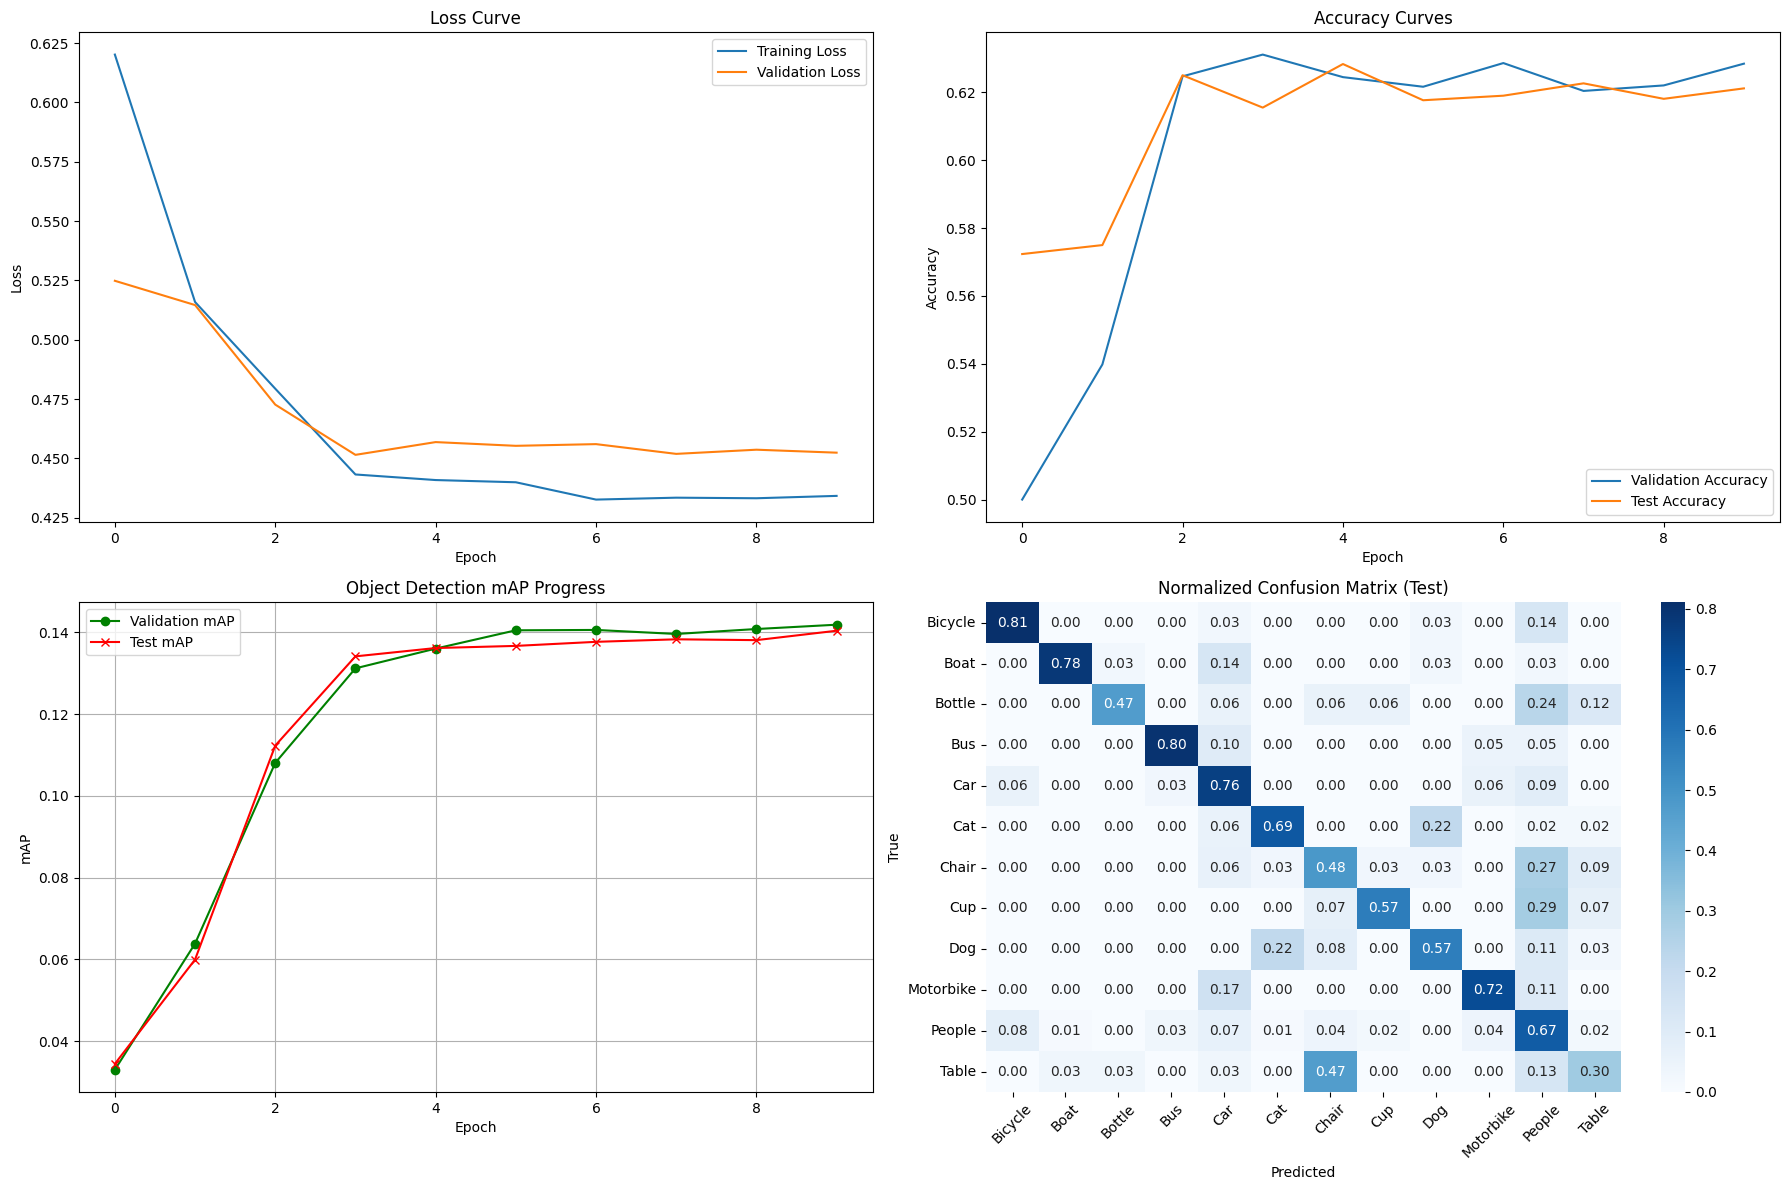

In [9]:
# Visualization (MODIFIED)
plt.figure(figsize=(18, 12))

# Loss Curve (train and validation)
plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(2, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# mAP Curve
plt.subplot(2, 2, 3)
plt.plot(val_map_history, color='green', marker='o', label='Validation mAP')
plt.plot(test_map_history, color='red', marker='x', label='Test mAP')
plt.title('Object Detection mAP Progress')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)

# Confusion Matrix (Test)
plt.subplot(2, 2, 4)
cm = confusion_matrix(all_test_targets, all_test_preds, labels=range(1, NUM_CLASSES))
row_sums = cm.sum(axis=1, keepdims=True)
cm = np.divide(cm.astype('float'), row_sums, where=row_sums != 0)
cm = np.nan_to_num(cm)

sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Normalized Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
plt.close()

In [10]:
# Classification Report (Test)
report = classification_report(
    all_test_targets, all_test_preds,
    target_names=CLASSES,
    labels=range(1, NUM_CLASSES),
    digits=4
)
print("\nClassification Report (Test):")
print(report)


Classification Report (Test):
              precision    recall  f1-score   support

     Bicycle     0.7317    0.8108    0.7692        37
        Boat     0.9355    0.7838    0.8529        37
      Bottle     0.8000    0.4706    0.5926        17
         Bus     0.7619    0.8000    0.7805        20
         Car     0.6800    0.7612    0.7183        67
         Cat     0.7778    0.6863    0.7292        51
       Chair     0.4000    0.4848    0.4384        33
         Cup     0.8000    0.5714    0.6667        28
         Dog     0.6000    0.5676    0.5833        37
   Motorbike     0.5909    0.7222    0.6500        18
      People     0.5794    0.6739    0.6231        92
       Table     0.4500    0.3000    0.3600        30

    accuracy                         0.6552       467
   macro avg     0.6756    0.6361    0.6470       467
weighted avg     0.6659    0.6552    0.6543       467



In [11]:
# Detailed Metrics (Test)
metrics_str = "\nDetailed Test Metrics:\n"
for key, value in map_metrics_test.items():
    if isinstance(value, torch.Tensor):
        if value.numel() == 1:
            metrics_str += f"{key:20}: {value.item():.4f}\n"
        else:
            metrics_str += f"{key:20}: {[round(v.item(), 4) for v in value]}\n"
print(metrics_str)


Detailed Test Metrics:
map                 : 0.1404
map_50              : 0.3443
map_75              : 0.0814
map_small           : 0.0286
map_medium          : 0.1467
map_large           : 0.2629
mar_1               : 0.1915
mar_10              : 0.2914
mar_100             : 0.3071
mar_small           : 0.0943
mar_medium          : 0.3472
mar_large           : 0.4633
map_per_class       : -1.0000
mar_100_per_class   : -1.0000
classes             : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



In [12]:
# Save Model
torch.save(model.state_dict(), 'detection_model_01.pth')
print("Training complete! Model saved.")

Training complete! Model saved.
